## House Price Fluctuation Analysis
We want to see if house prices fluctuate consistently in the US throughout the year. We'll do that using the FHFA House Prices Indexes dataset provided at <https://catalog.data.gov/dataset/fhfa-house-price-indexes-hpis-948c6>. Specifically we want to see if the data reveals a preferred time of year for house purchases.

### Importing and inspecting data

In [381]:
import pandas as pd
import matplotlib.pyplot as plt

hpi_data = pd.read_csv('HPI_master.csv')
hpi_data.info()
hpi_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122307 entries, 0 to 122306
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   hpi_type    122307 non-null  object 
 1   hpi_flavor  122307 non-null  object 
 2   frequency   122307 non-null  object 
 3   level       122307 non-null  object 
 4   place_name  122307 non-null  object 
 5   place_id    122307 non-null  object 
 6   yr          122307 non-null  int64  
 7   period      122307 non-null  int64  
 8   index_nsa   122306 non-null  float64
 9   index_sa    40625 non-null   float64
dtypes: float64(2), int64(2), object(6)
memory usage: 9.3+ MB


,hpi_type,hpi_flavor,frequency,level,place_name,place_id,yr,period,index_nsa,index_sa
0,traditional,purchase-only,monthly,USA or Census Division,East North Central Division,DV_ENC,1991,1,100.00,100.00
1,traditional,purchase-only,monthly,USA or Census Division,East North Central Division,DV_ENC,1991,2,100.91,100.97
2,traditional,purchase-only,monthly,USA or Census Division,East North Central Division,DV_ENC,1991,3,101.31,100.92
3,traditional,purchase-only,monthly,USA or Census Division,East North Central Division,DV_ENC,1991,4,101.70,100.99
4,traditional,purchase-only,monthly,USA or Census Division,East North Central Division,DV_ENC,1991,5,102.33,101.36
...,...,...,...,...,...,...,...,...,...,...
122302,developmental,purchase-only,quarterly,Puerto Rico,Puerto Rico,PR,2022,1,186.09,188.99
122303,developmental,purchase-only,quarterly,Puerto Rico,Puerto Rico,PR,2022,2,181.12,181.35
122304,developmental,purchase-only,quarterly,Puerto Rico,Puerto Rico,PR,2022,3,200.44,195.62
122305,developmental,purchase-only,quarterly,Puerto Rico,Puerto Rico,PR,2022,4,194.29,197.19


### Preparing and processing the data
It looks like only index_sa has null values, which is okay since we're not using that data. Monthly data would be the most useful here, let's see which levels have it.

In [382]:
hpi_monthly = hpi_data.query('frequency == "monthly"')
pd.Series(hpi_monthly['level'].unique())

0    USA or Census Division
dtype: object

There's only monthly data at the national and regional levels, it's a fair guess that house prices fluctuate differently in different climates, so let's work with regional data.

In [383]:
pd.Series(hpi_monthly['place_name'].unique())

0    East North Central Division
1    East South Central Division
2       Middle Atlantic Division
3              Mountain Division
4           New England Division
5               Pacific Division
6        South Atlantic Division
7    West North Central Division
8    West South Central Division
9                  United States
dtype: object

In [384]:
hpi_data.query('frequency == "monthly"', inplace=True)
hpi_data.query('place_name != "United States"', inplace=True)
hpi_data

,hpi_type,hpi_flavor,frequency,level,place_name,place_id,yr,period,index_nsa,index_sa
0,traditional,purchase-only,monthly,USA or Census Division,East North Central Division,DV_ENC,1991,1,100.00,100.00
1,traditional,purchase-only,monthly,USA or Census Division,East North Central Division,DV_ENC,1991,2,100.91,100.97
2,traditional,purchase-only,monthly,USA or Census Division,East North Central Division,DV_ENC,1991,3,101.31,100.92
3,traditional,purchase-only,monthly,USA or Census Division,East North Central Division,DV_ENC,1991,4,101.70,100.99
4,traditional,purchase-only,monthly,USA or Census Division,East North Central Division,DV_ENC,1991,5,102.33,101.36
...,...,...,...,...,...,...,...,...,...,...
3487,traditional,purchase-only,monthly,USA or Census Division,West South Central Division,DV_WSC,2022,12,402.83,404.66
3488,traditional,purchase-only,monthly,USA or Census Division,West South Central Division,DV_WSC,2023,1,398.48,401.35
3489,traditional,purchase-only,monthly,USA or Census Division,West South Central Division,DV_WSC,2023,2,406.55,407.36
3490,traditional,purchase-only,monthly,USA or Census Division,West South Central Division,DV_WSC,2023,3,409.48,408.29


Okay, now we're just working with monthly regional data from January 1991 to April 2023. Let's make sure there aren't any anomalies in the remaining descriptive columns.

In [385]:
pd.Series({c:hpi_data[c].unique() for c in hpi_data.loc[:,'hpi_type':'frequency']})

hpi_type        [traditional]
hpi_flavor    [purchase-only]
frequency           [monthly]
dtype: object

We'll drop unnecessary columns to tidy up the data, give some columns more descriptive names, and create a monthly percent change column.

In [386]:
hpi_data.drop(columns=['hpi_type', 'hpi_flavor', 'frequency', 'level', 'place_id', 'index_sa'], inplace=True)
hpi_data.rename(columns={'yr':'year', 'period':'month'}, inplace = True)
hpi_data['index_delta'] = hpi_data.groupby(['place_name'])['index_nsa'].pct_change().multiply(100)
hpi_data

,place_name,year,month,index_nsa,index_delta
0,East North Central Division,1991,1,100.00,NaN
1,East North Central Division,1991,2,100.91,0.910000
2,East North Central Division,1991,3,101.31,0.396393
3,East North Central Division,1991,4,101.70,0.384957
4,East North Central Division,1991,5,102.33,0.619469
...,...,...,...,...,...
3487,West South Central Division,2022,12,402.83,-0.675592
3488,West South Central Division,2023,1,398.48,-1.079860
3489,West South Central Division,2023,2,406.55,2.025196
3490,West South Central Division,2023,3,409.48,0.720699


### Analyzing the data
First we'll see if the full set of data shows any kind of monthly trend.

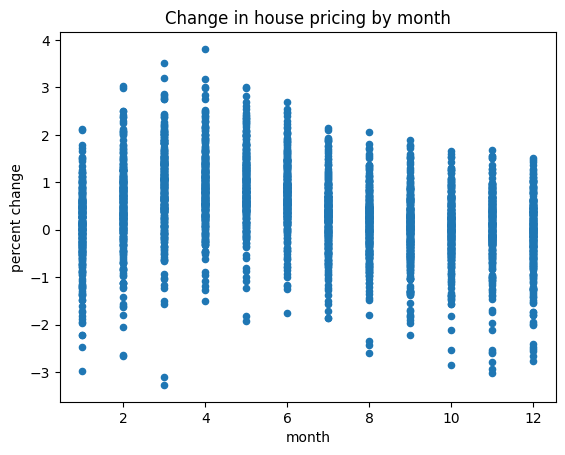

In [387]:
hpi_data.plot(
        kind='scatter', 
        x='month', 
        y='index_delta',
        xlabel='month',
        ylabel='percent change',
        title='Change in house pricing by month'
        )
plt.show()

It looks like price changes peak in spring and valley in fall/winter. We'll see how monthly averages look across regions.

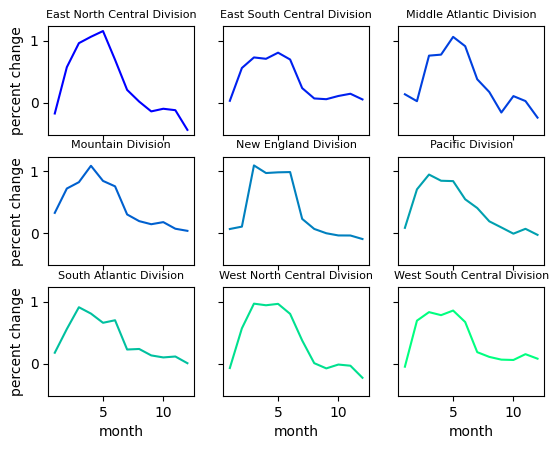

In [388]:
axes = pd.pivot_table(
        hpi_data, index='month', 
        columns='place_name', 
        values='index_delta'
        ).plot(
        xlabel='month', 
        ylabel='percent change', 
        title=list(hpi_data['place_name'].unique()),
        legend=False,
        colormap='winter',
        subplots=True,
        sharey=True,
        layout=(3,3)
        )
for a in axes.reshape(-1):
    a.title.set_size(8)
plt.show()

As you might expect, the trend is less extreme in warmer regions, though still present. 
## Conclusion
In every region it seems it would be smarter to make purchases before the spring price surge, and in some regions the prices even tend to drop some in the winter. While not a massive fluctuation, it's fair to say that for the price of a house, it's worth taking into account when weighing the pros and cons of when to buy.